# Clustering Analysis

We'll be using a [power consumption dataset](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) to explore some clustering techniques.

## Load Libs

In [35]:
# import libs
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Mount Google Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

## Download dataset

In [3]:
# Download the dataset
!wget --no-check-certificate \
    https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip \
    -O /tmp/household_power_consumption.zip

--2020-08-06 23:49:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘/tmp/household_power_consumption.zip’

/tmp/household_powe 100%[===================>]  19.68M  10.8MB/s    in 1.8s    

2020-08-06 23:49:31 (10.8 MB/s) - ‘/tmp/household_power_consumption.zip’ saved [20640916/20640916]



In [4]:
# create folder
! mkdir /tmp/household_power_consumption
# unzip file
! unzip /tmp/household_power_consumption.zip -d /tmp/household_power_consumption

Archive:  /tmp/household_power_consumption.zip
  inflating: /tmp/household_power_consumption/household_power_consumption.txt  


## Load dataset

### Data Set Information:

## **For this exercise we'll consider each row to be a single user consumption ##

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

This archive contains **2075259** measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes:

1. (`global_active_power`*1000/60 - `sub_metering_1` - `sub_metering_2` - `sub_metering_3`) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



### Attribute Information:

1. `date`: Date in format `dd/mm/yyyy`
2. `time`: time in format `hh:mm:ss`
3. `global_active_power`: household global minute-averaged active power (in kilowatt)
4. `global_reactive_power`: household global minute-averaged reactive power (in kilowatt)
5. `voltage`: minute-averaged voltage (in volt)
6. `global_intensity`: household global minute-averaged current intensity (in ampere)
7. `sub_metering_1`: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. `sub_metering_2`: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. `sub_metering_3`: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [5]:
# set the dtypes to load them as the propoer types
#load_types = {'Global_active_power': 'float', 
#              'Global_reactive_power': 'float', 
#              'Voltage': 'float', 
#              'Global_intensity': 'float', 
#              'Sub_metering_1': 'float', 
#              'Sub_metering_2': 'float', 
#              'Sub_metering_3': 'float'}

# Load the dataset
dataset = pd.read_csv('/tmp/household_power_consumption/household_power_consumption.txt', 
                      delimiter = ';', 
                    #   dtype=load_types,
                      low_memory = True)

# Exploratory Data Analysis

In [6]:
dataset.shape

(2075259, 9)

There must be some issue with most columns, because it will not let us convert to float on load. We'll get back there on time.

In [7]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [8]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Transforming the columns to numeric 

First of all, we'll remove the date and time columns for the purpose of the exercise on this notebook.

In [9]:
# select all rows and columns 2, 3, till the last
dataset = dataset.iloc[:, 2:]

In [10]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
pd.to_numeric(dataset['Global_active_power'])

ValueError: ignored

In [12]:
dataset.iloc[6839]

Global_active_power        ?
Global_reactive_power      ?
Voltage                    ?
Global_intensity           ?
Sub_metering_1             ?
Sub_metering_2             ?
Sub_metering_3           NaN
Name: 6839, dtype: object

OK. It seems that we have data that were wrongly inputed to the datastet, therefore we can not convert it to the disered numeric format.

Let's replace the `?` on the string columns to be able to convert them to numeric.

In [13]:
# replace '?' with Null
dataset = dataset.replace('?', '')

In [14]:
# convert to numeric
dataset['Global_active_power'] = pd.to_numeric(dataset['Global_active_power'])
dataset['Global_reactive_power'] = pd.to_numeric(dataset['Global_reactive_power'])
dataset['Voltage'] = pd.to_numeric(dataset['Voltage'])
dataset['Global_intensity'] = pd.to_numeric(dataset['Global_intensity'])
dataset['Sub_metering_1'] = pd.to_numeric(dataset['Sub_metering_1'])
dataset['Sub_metering_2'] = pd.to_numeric(dataset['Sub_metering_2'])
dataset['Sub_metering_3'] = pd.to_numeric(dataset['Sub_metering_3'])

In [15]:
dataset.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

## Missing Data

Let's check for missing data.

In [16]:
# missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Sub_metering_3,25979,0.012518
Sub_metering_2,25979,0.012518
Sub_metering_1,25979,0.012518
Global_intensity,25979,0.012518
Voltage,25979,0.012518
Global_reactive_power,25979,0.012518
Global_active_power,25979,0.012518


All the columns have ~1% missing data. As it's a very little proportion to the total, we could delete all these missing rows.

In [17]:
# romeve all the rows with missing data
dataset = dataset.dropna(axis=0)

In [18]:
# missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Sub_metering_3,0,0.0
Sub_metering_2,0,0.0
Sub_metering_1,0,0.0
Global_intensity,0,0.0
Voltage,0,0.0
Global_reactive_power,0,0.0
Global_active_power,0,0.0


# Working with 1% data sample

As we're working with a lot of data and we might have limited resources to process all this data, we can work with a sample of the dataset that reflects the whole dataset.

In this case we'll work with a sample of size `1% of the dataset`, nonetheless we could also work with another proportionsas well.

In [19]:
print(f"Size of the whole dataset: {dataset.shape[0]} rows")

Size of the whole dataset: 2049280 rows


In [20]:
# retrive a sample of dataset
_, dataset = train_test_split(dataset, test_size=0.01)

In [24]:
print(f"Size of the sample dataset: {dataset.shape[0]} rows")

Size of the sample dataset: 20493 rows


In [21]:
dataset.shape

(20493, 7)

In [22]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1285125,0.402,0.174,234.79,1.8,0.0,0.0,1.0
1504467,0.230,0.000,242.12,0.8,0.0,0.0,0.0
1977841,0.756,0.214,242.31,3.2,0.0,0.0,11.0
1692177,0.984,0.066,241.91,4.0,0.0,1.0,1.0
603319,0.468,0.068,242.83,2.2,0.0,0.0,0.0


# Finding the best K value



Execution time: 45.06 seconds.


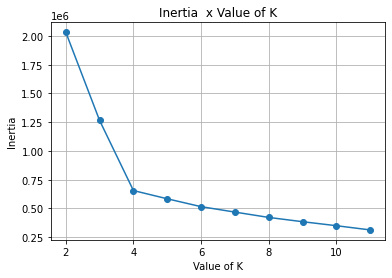

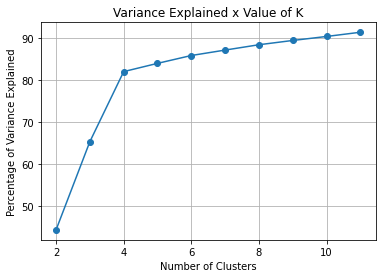

In [37]:
# Inertia = (Squared) Sum of sample distances to your nearest cluster.
start = time()
# List of K values
Ks = range(2, 12)

metrics = []
centroids = []

# loop through K values
for K in Ks:
    model = KMeans(n_clusters = K, random_state = 101)
    model.fit(dataset)
    metrics.append(model.inertia_)
    centroids.append(model.cluster_centers_)

# Calculating the Euclidean distance from each data point to the centroid
k_euclid = [cdist(dataset, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Sum of squares of distances within the cluster (inertia)
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Total sum of squares
soma_total = sum(pdist(dataset)**2)/dataset.shape[0]

# Sum of squares between clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# print execution time
print(f"Execution time: {time() - start:.2f} seconds.")

# plot inertia
plt.plot(Ks, metrics, 'o-')
plt.xlabel("Value of K")
plt.ylabel("Inertia")
plt.title('Inertia  x Value of K')
plt.grid(axis='both')
plt.show()

# plot Variance Explained
# Inertia / (Squared) Pairwise distances between observations in dataset
# or 
# (Squared) Sum of sample distances to your nearest cluster / (Squared) Pairwise distances between observations in dataset
plt.plot(Ks, soma_quadrados_inter_cluster/soma_total * 100, 'o-')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of Variance Explained')
plt.title('Variance Explained x Value of K')
plt.show()

The inertia measured is the squared sum of the sample distances to their nearest cluster. 

We can observe that the inertia shrunk greatly at the early steps until the K-value of 4. The steps afterwards decreased at a slower pace. That means that it was "easy" for the model to divide the data up until it was divided in 4 clusters. After that it was "harder" to further divide the dataset. That is known as the "Elbow-curve".

Nonetheless, that doesn't mean that there is a correct answer to how many clusters to create. It depends on the business problem and also on what your goals with the analysis are.

For my analysis I've no previous deep knowledge on the business, therefore I'll consider a smaller number of clusters, but more crearly well divided using the dataset we've got. I'll use 4 clusters to divide my dataset for that purpose.

# Create K-Means Model

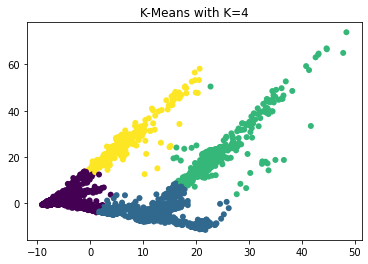

In [43]:
# transform the dataset to 2D 
dataset_pca = PCA(n_components=2).fit_transform(dataset)

# model with K = 4
modelo_v1 = KMeans(n_clusters = 4)

# predict the clusters
y_km = modelo_v1.fit_predict(dataset_pca)

# plot a 2D scatter plot
plt.title(f"K-Means with K={len(set(modelo_v1.labels_))}")
plt.scatter(dataset_pca[:, 0], dataset_pca[:, 1], c = y_km, edgecolors = 'none')
plt.show()

## Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [45]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(dataset_pca, labels, metric = 'euclidean')

0.8568965629132594

# References

- https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

- https://en.wikipedia.org/wiki/Silhouette_(clustering)

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

- https://scikit-learn.org/stable/modules/clustering.html